# Agent-Based Modelling

### _Shreya Raghavendra (13756877), Boyan Mihaylov (15067602), Eline van de Lagemaat (11892900), Sofia Tavitian (14824248), Chayenne Olumuyiwa (12055662)_

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import pyarrow as pa
import pyarrow.parquet as pq

from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'notebook'

from scipy.signal import find_peaks
from scipy.signal import savgol_filter

# from functions.read_data import read_history

# graph font settings
rcParams['font.family'] = "serif"     
rcParams['font.size']=12

In [20]:
def phase_space_2d(data, output_var='Trees', input_var='harvest_nbrs', input_value=3, start_step=50):
    subset = data[data[input_var] == input_value]
    subset = subset.sort_values(by=['Step', 'RunId'])

    # Compute mean and derivative over the 20 runs for each time step
    mean_output = subset.groupby('Step')[output_var].mean().values
    derivative_output = np.gradient(mean_output)

    # Consider only the data from the specified start step onwards
    mean_output = mean_output[start_step:]
    derivative_output = derivative_output[start_step:]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mean_output, derivative_output, label=f'Derivative vs {output_var}', color='blue')
    plt.xlabel(output_var)
    plt.ylabel(f'Derivative of {output_var}')
    plt.title(f'{output_var} vs Derivative for {input_var} = {input_value}')
    plt.legend()
    plt.grid(True)
    plt.show()

def phase_space_3d(data, output_var='Trees', input_var='harvest_nbrs', start_step=50):
    # Initialize lists to store the results
    input_var_values = sorted(data[input_var].unique())
    output_means = []
    output_derivatives = []

    # Process each unique value of the input variable
    for input_value in input_var_values:
        subset = data[data[input_var] == input_value]
        # Ensure the data is sorted by Step and RunId
        subset = subset.sort_values(by=['Step', 'RunId'])
        # Compute mean output variable over the 20 runs for each time step
        mean_output = subset.groupby('Step')[output_var].mean().values
        # Compute the derivative of the mean output variable
        derivative_output = np.gradient(mean_output)
        # Store the results starting from the specified start step
        output_means.append(mean_output[start_step:])
        output_derivatives.append(derivative_output[start_step:])

    # Convert lists to arrays for plotting
    output_means = np.array(output_means)
    output_derivatives = np.array(output_derivatives)

    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting
    for i, input_value in enumerate(input_var_values):
        ax.plot(input_value * np.ones_like(output_means[i]), output_means[i], output_derivatives[i], lw=0.5)

    # Labels
    ax.set_xlabel(input_var)
    ax.set_ylabel(output_var)
    ax.set_zlabel(f'Derivative of {output_var}')

    plt.title(f'Phase space plot of {output_var} for Various Values of {input_var}')
    plt.show()

In [8]:
problem = {
    'num_vars': 5,
    'names': ['harvest_volume', 'harvest_nbrs', 'harvest_prob', 'fert_comp_ratio_exponent', 'top_n_sites_percent'],
    'bounds': [[50, 300],
               [0, 8],
               [0, 1],
               [-1, 1],
               [0, 1]]
}

outputs = ["Trees", "Fungi", "Living Trees Total Volume", "Harvested volume", "Infected Trees", "Mean Substrate", "Mean Soil Fertility"]

In [11]:
n_max_timesteps=1000
n_replicates=20
n_distinct_samples=64
seed=42
table_read = pq.read_table(f'sa_results_seed_42.parquet')
data = table_read.to_pandas()
data

,RunId,Step,harvest_volume,harvest_nbrs,harvest_prob,fert_comp_ratio_exponent,top_n_sites_percent,Trees,Fungi,Living Trees Total Volume,Infected Trees,Mean Substrate,Mean Soil Fertility,Harvested volume,SimId
0,0,0,55.859375,3,0.820312,0.671875,0.648438,100,50,13751.000000,0,1.0100,0.487769,0.000000,0
1,0,1,55.859375,3,0.820312,0.671875,0.648438,80,34,10569.759921,0,0.9500,0.177334,3312.968217,0
2,0,2,55.859375,3,0.820312,0.671875,0.648438,80,45,10649.989006,11,0.9275,0.143895,0.000000,0
3,0,3,55.859375,3,0.820312,0.671875,0.648438,80,27,10720.647941,11,0.9025,0.140196,0.000000,0
4,0,4,55.859375,3,0.820312,0.671875,0.648438,339,21,11048.021320,11,0.8975,0.125871,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15375355,19,996,133.984375,1,0.070312,-0.171875,0.539062,400,0,4361.993691,43,0.0425,0.077338,0.000000,15359
15375356,19,997,133.984375,1,0.070312,-0.171875,0.539062,397,58,4146.919490,42,0.0475,0.070764,290.611472,15359
15375357,19,998,133.984375,1,0.070312,-0.171875,0.539062,397,10,4222.785383,42,0.0225,0.091760,0.000000,15359
15375358,19,999,133.984375,1,0.070312,-0.171875,0.539062,397,10,4299.345993,42,0.0200,0.087184,0.000000,15359


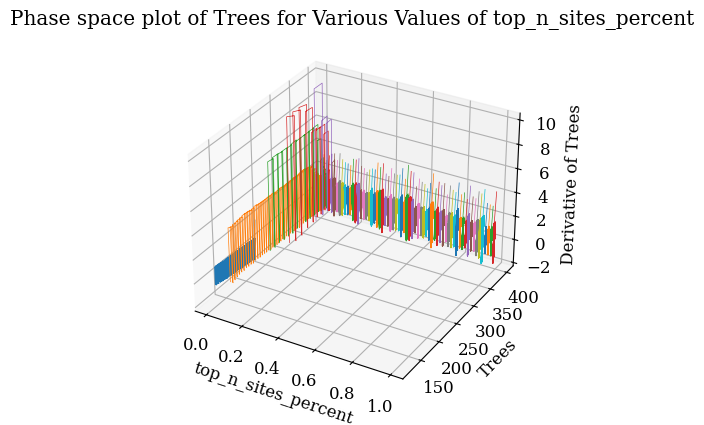

In [34]:
phase_space_2d(data, output_var='Trees', input_var='harvest_nbrs', input_value=5, start_step=50)
phase_space_3d(data, output_var='Trees', input_var='top_n_sites_percent', start_step=50)